
# Кластеризация одномерных данных.

## Преподготовка

Импортируем библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import geopandas as gpd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

%pip install jenkspy
%pip install ckmeans-1d-dp

import jenkspy
from ckmeans_1d_dp import ckmeans

Загружаем и подготавливаем данные

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/НИР/v9123 1.xlsx')
df = np.array(data['value']).reshape(-1, 1)

Визуализируем полученные данные

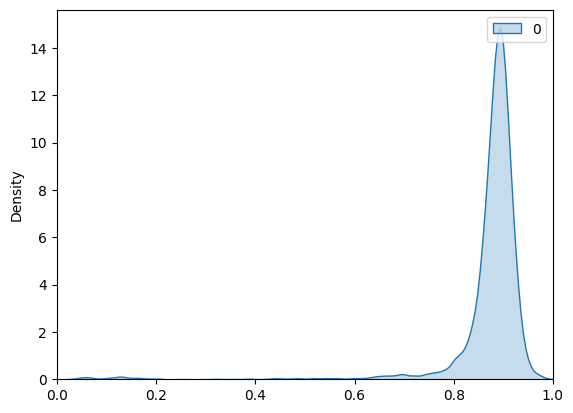

In [ ]:
sns.kdeplot(df, fill=True, bw_adjust=0.5)
plt.xlim(0, 1)
plt.show()

## Метрики оценки качества кластеризации

### Внутрикластерная сумма квадратов отклонений (WSS)

**Принцип работы**

Для каждого кластера вычисляем сумма квадратов расстояний всех точек этого кластера до его центроида (среднего значения). Затем эти суммы суммируем по всем кластерам.
$$ WSS = \sum\limits_{j=1}^{k} \sum\limits_{x_i \in C_j} \|x_i - \mu_j \|^2, $$ где $C_j - j$-ый кластер, $\mu_j$ - центороид $j$-го кластера, $x_i$ - точка данных в кластере $C_j$

Оптимальное число кластеров определяется методом "локтя" (Elbow Method), где выбирается такое k, при котором дальнейшее увеличение числа кластеров приводит к незначительному уменьшению WSS.

WSS полезна для определения оптимального числа кластеров с помощью метода локтя, но сама по себе не предоставляет информации о качестве разделения кластеров.

### Индекс силуэта (Silhouette Score)

Silhouette Score (Индекс силуэта) — это метрика, оценивающая, насколько хорошо каждая точка вписывается в свой кластер по сравнению с другими кластерами.

**Принцип работы**

Для каждой точки данных рассчитывается два показателя: среднее расстояние до всех других точек в том же кластере (a) и минимальное среднее расстояние до точек из соседнего кластера (b)

Индекс силуэта для точки вычисляется как:
$$s = \frac{b-a}{\max(a,b)}$$

Средний Silhouette Score для всей кластеризации варьируется от -1 до 1:

Ближе к 1: Хорошее разделение и плотные кластеры.

Ближе к 0: Перекрытие кластеров.

Меньше 0: Некорректное присвоение кластеров.

Silhouette Score фокусируется на индивидуальной точке, оценивая её относительную близость к своему кластеру по сравнению с соседними кластерами.

### Индекс Калински-Харабаса (Calinski-Harabasz Index)

Calinski-Harabasz Index (Индекс Калински-Харабаса), также известный как Variance Ratio Criterion, оценивает качество кластеризации, сравнивая межкластерную дисперсию с внутрикластерной дисперсией.

**Принцип работы**

Индекс рассчитывает отношение между межкластерной дисперсией (различие между центроидами кластеров и общим центроидом данных) и внутрикластерной дисперсией (сумма квадратов отклонений точек от центроидов своих кластеров).

 Более высокое значение индекса указывает на лучшее качество кластеризации.

Calinski-Harabasz Index оценивает общую структуру кластеризации, сравнивая межкластерную и внутрикластерную дисперсии.


## Метод K-средних

**Цель алгоритма**

Разделить набор одномерных данных на k кластеров таким образом, чтобы внутрикластерная сумма квадратов отклонений (WSS) была минимальной, а кластеры были максимально компактными и разнесенными друг от друга.

**Описание алгоритма**

1. Определяем количество кластеров.
2. Выбераем случайно k точек из набора данных в качестве начальных центроидов кластеров.
3. Для каждой точки $x_i$ из набора данных вычисляем расстояние (абсолютное значение разности) до каждого из k центроидов.
4. Присваиваем каждую точку $x_i$ тому кластеру, центроид которого находится ближе всего.
5. Пересчитываем центроиды. Для каждого кластера вычисляем новый центроид как среднее значение всех точек, принадлежащих этому кластеру.
6. Проверяем сходимость. Если ни одна точка не изменила свой кластер между итерациями или достигнуто максимальное число итераций, то завершаем процесс.

In [ ]:
def compute_wss(X, labels):
    wss = 0.0
    for cluster_id in np.unique(labels):
        cluster_points = X[labels == cluster_id]
        centroid = np.mean(cluster_points)
        wss += np.sum((cluster_points - centroid)**2)
    return wss

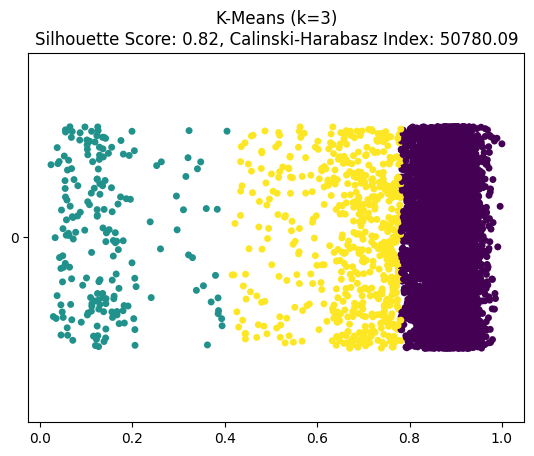

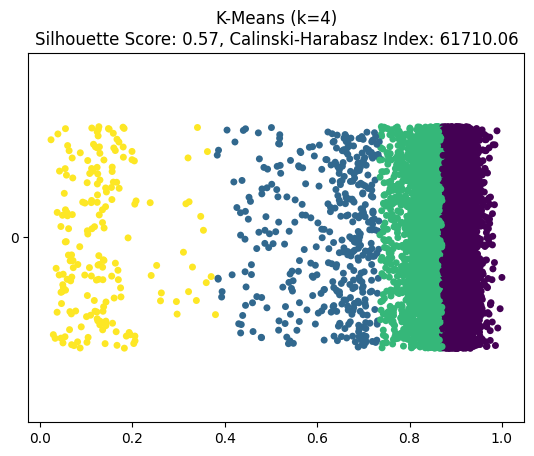

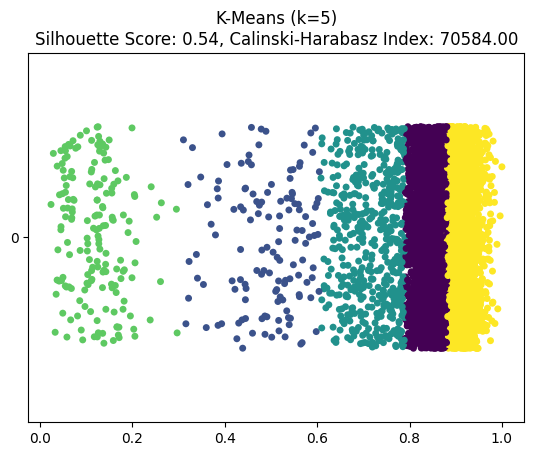

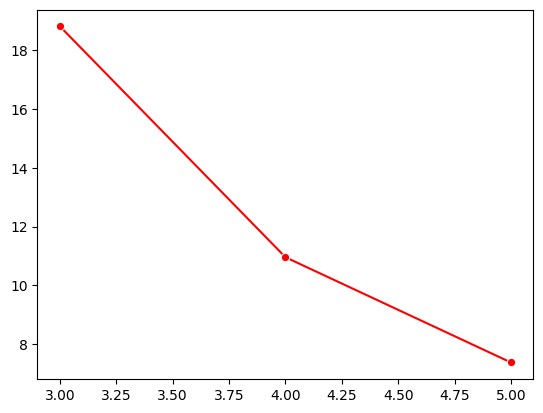

[K-Means] Оптимальное k по Calinski-Harabasz: 5, score: 70584.00
[K-Means] Оптимальное k по Silhouette: 3, score: 0.82
[K-Means] Оптимальное k по WSS: 4


In [ ]:
wss_values = []
silhouette_values = []
calinski_values = []
k_range = range(3, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    wss_values.append(kmeans.inertia_)

    s_score = silhouette_score(df, labels)
    silhouette_values.append(s_score)

    ch_score = calinski_harabasz_score(df, labels)
    calinski_values.append(ch_score)


    sns.stripplot(data=df, jitter=0.3, c=kmeans.labels_, orient="h")
    plt.title(f"K-Means (k={k})\nSilhouette Score: {s_score:.2f}, "
              f"Calinski-Harabasz Index: {ch_score:.2f}")
    plt.show()


sns.lineplot(x=list(k_range), y=wss_values, marker='o', color='red')
plt.show()

best_k_ch = k_range[np.argmax(calinski_values)]
best_ch_score = max(calinski_values)

best_k_sil = k_range[np.argmax(silhouette_values)]
best_sil_score = max(silhouette_values)

print(f"[K-Means] Оптимальное k по Calinski-Harabasz: {best_k_ch}, score: {best_ch_score:.2f}")
print(f"[K-Means] Оптимальное k по Silhouette: {best_k_sil}, score: {best_sil_score:.2f}")
print(f"[K-Means] Оптимальное k по WSS: 4")

## Метод естественных разрывов Дженкса.

**Цель алгоритма:**

Определить оптимальные границы классов для одномерных данных таким образом, чтобы минимизировать внутриклассовую вариацию и максимизировать межклассовую вариацию. Это позволяет выявить естественные группы или кластеры в данных.

**Описание алгоритма:**
1. Упорядочиваем данные по возрастанию.
2. Выбираем количество классов.
3. Предварительно разбиваем данные на классы на равные интервалы.
4. Находим сумму квадратов отклонений для массива (SDAM)
$$ SDAM = \sum\limits_{i=1}^{n}(x_i-\mu)^2,$$ где  $\mu$ - среднее значение всего массива данных.
5. Оцениваем суммы квадратов отклонений внутри каждого класса (SDCM)
$$ SDCM = \sum\limits_{j=1}^{k}\sum\limits_{x_i\in C_j}(x_i-\mu)^2$$, где $C_j - j$-ый класс, $\mu_j$ -  среднее значение $j$-го класса.
6. Находим минимальные суммы квадратов отклонений между классами
7. Перемещем точки данных между классами и пересчитывание SDCM для каждого варианта разбиения.
8. В качестве итогового показателя рассчитываем “соответствие с высокой степенью отклонения” (GVF), определяемое как
$$ \frac{(SDAM — SCDM)}{SDAM}. $$
GVF варьируется от 1 (идеальное соответствие) до 0 (ужасное соответствие).
9. Повторяем шаги 7 и 8, постепенно улучшая разбиение классов до тех пор, пока SDCM не станет минимальной, а GVF не достигнет максимума.



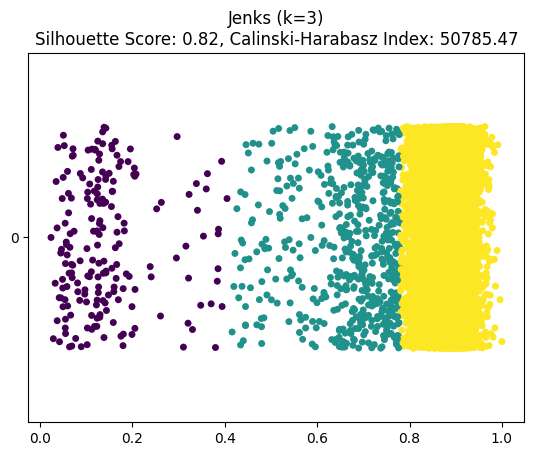

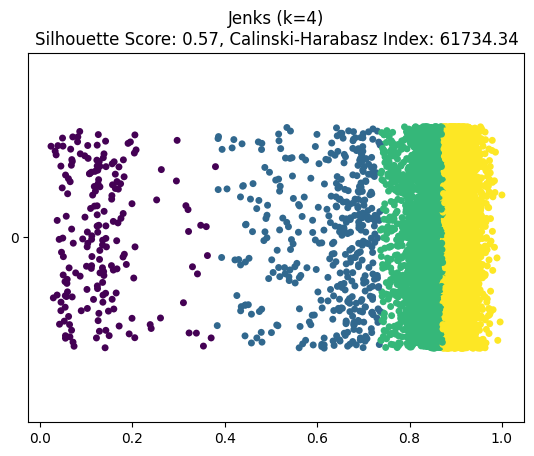

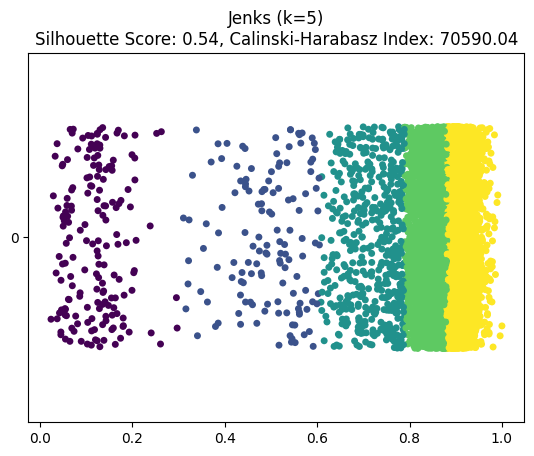

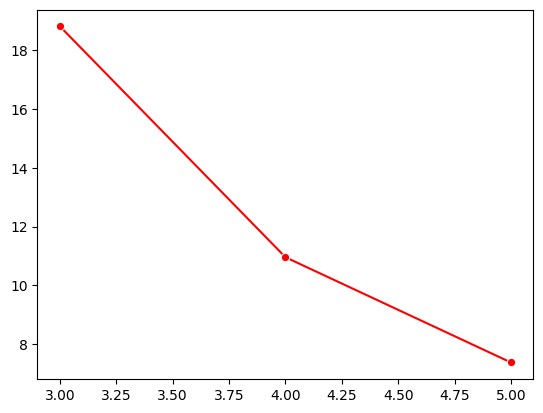

[Jenks] Оптимальное k по Calinski-Harabasz: 5, score: 70590.04
[Jenks] Оптимальное k по Silhouette: 3, score: 0.82
[Jenks] Оптимальное k по WSS: 4


In [ ]:
jenks_sil = []
jenks_ch = []
jenks_wss = []

for k in k_range:
    breaks = jenkspy.jenks_breaks(data['value'], n_classes=k)
    labels = pd.cut(data['value'], bins=breaks, labels=False, include_lowest=True)
    labels = np.array(labels)


    s_score = silhouette_score(df, labels)
    ch_score = calinski_harabasz_score(df, labels)
    wss_value = compute_wss(df, labels)

    jenks_sil.append(s_score)
    jenks_ch.append(ch_score)
    jenks_wss.append(wss_value)

    sns.stripplot(data=df, jitter=0.3, c=labels, orient="h")
    plt.title(f"Jenks (k={k})\nSilhouette Score: {s_score:.2f}, "
              f"Calinski-Harabasz Index: {ch_score:.2f}")
    plt.show()

sns.lineplot(x=list(k_range), y=wss_values, marker='o', color='red')
plt.show()

best_k_jenks_ch = k_range[np.argmax(jenks_ch)]
best_k_jenks_sil = k_range[np.argmax(jenks_sil)]

print(f"[Jenks] Оптимальное k по Calinski-Harabasz: {best_k_jenks_ch}, "
      f"score: {max(jenks_ch):.2f}")
print(f"[Jenks] Оптимальное k по Silhouette: {best_k_jenks_sil}, "
      f"score: {max(jenks_sil):.2f}")
print(f"[Jenks] Оптимальное k по WSS: 4")


## Оптимизированный метод K-средних

**Цель алгоритма**

Разделить одномерный набор данных на k кластеров таким образом, чтобы внутрикластерная сумма квадратов отклонений (WSS) была минимальной. Метод Ckmeans.1d.dp использует динамическое программирование для обеспечения оптимального разбиения, избегая локальных минимумов (значение функции потерь, которое меньше или равно значениям в некоторой окрестности, но не обязательно является наименьшим возможным значением), характерных для стандартного алгоритма K-средних.

**Описание алгоритма**

1. Упорядочиваем данные по возврастанию
2. Вычисляем кумулятивные суммы
$$ sum[i] = \sum\limits_{j=1}^{i} x_j $$
и
$$ sum2[i] =\sum\limits_{j=1}^{i} x_j^2  $$
3. Создаем таблицу минимальных затрат dp  размером $n\times k$, $n$ - число данных, $k$ - число кластеров.
$dp[i][j]$:= Минимальная сумма квадратов отклонений для первых i элементов, разделенных на j кластеров
4. Создаем таблицу предшествующих разрывов backtrack размером $n\times k$.
$backtrack[i][j]$ := Индекс последнего разрыва перед j кластером для первых i элементов
5. Заполнение базовых случаев.
$dp[i][1]$=Вычисление суммы квадратов отклонений для первых i элементов как одного кластера. $backtrack[i][1]=0$
6. Основной цикл динамического программирования. Для каждого числа кластеров j от 2 до k и для каждого числа элементов i от j до n находим оптимальный разрыв m:
$$ dp[i][j]= \min\limits_{m=j=1}^{i-1} (dp[m][j-1] + SS(m+1, i))$$
, где $SS(m+1,i)$ - сумма квадратов отклонений для подотрезка от m+1 до i:
$$ SS(m+1,i) = sum2[i] -sum2[m] - \frac{(sum[i]-sum[m])^2}{i-m}$$
7. Индексы разрывов сохраняем в backtrack.

На основе найденных разрывов разделяем данные на k кластеров.


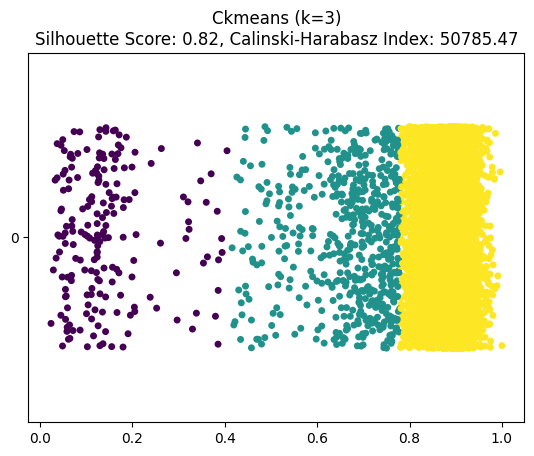

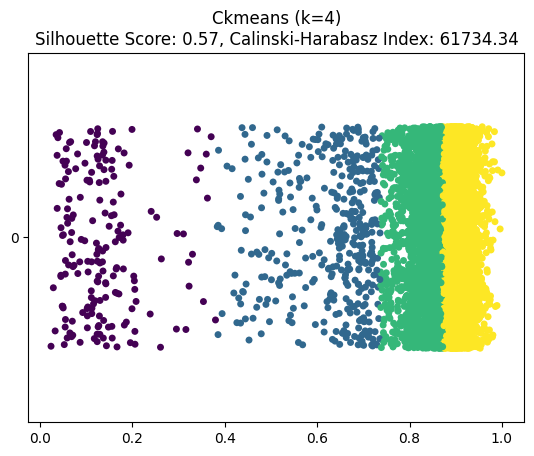

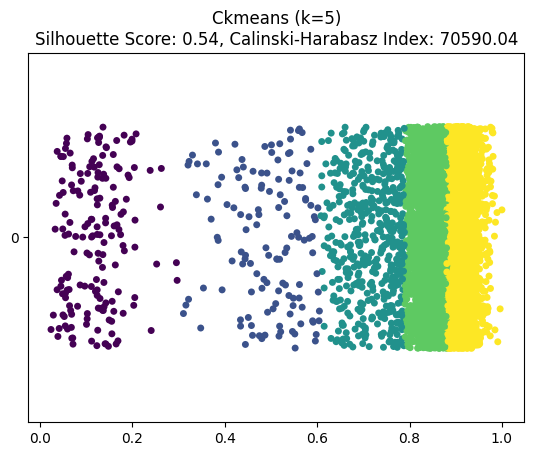

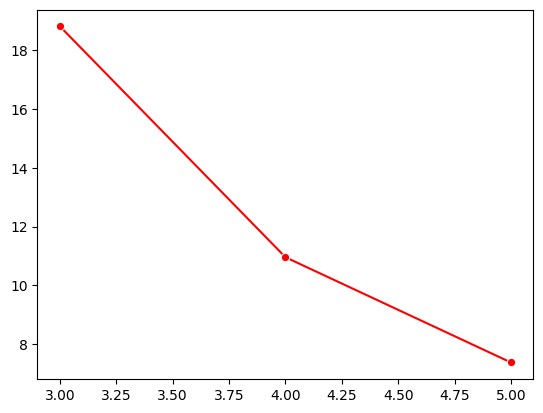

[Ckmeans] Оптимальное k по Calinski-Harabasz: 5, score: 70590.04
[Ckmeans] Оптимальное k по Silhouette: 3, score: 0.82
[Ckmeans] Оптимальное k по WSS: 4


In [ ]:
ckm_sil = []
ckm_ch = []
ckm_wss = []

for k in k_range:
    ckmeans_result = ckmeans(df.flatten(), k)
    labels = np.array(ckmeans_result[0])

    s_score = silhouette_score(df, labels)
    ch_score = calinski_harabasz_score(df, labels)
    wss_value = compute_wss(df, labels)

    ckm_sil.append(s_score)
    ckm_ch.append(ch_score)
    ckm_wss.append(wss_value)

    sns.stripplot(data=df, jitter=0.3, c=ckmeans_result.cluster, orient="h")
    plt.title(f"Ckmeans (k={k})\nSilhouette Score: {s_score:.2f}, "
              f"Calinski-Harabasz Index: {ch_score:.2f}")
    plt.show()

sns.lineplot(x=list(k_range), y=wss_values, marker='o', color='red')
plt.show()


best_k_ckm_ch = k_range[np.argmax(ckm_ch)]
best_k_ckm_sil = k_range[np.argmax(ckm_sil)]

print(f"[Ckmeans] Оптимальное k по Calinski-Harabasz: {best_k_ckm_ch}, "
      f"score: {max(ckm_ch):.2f}")
print(f"[Ckmeans] Оптимальное k по Silhouette: {best_k_ckm_sil}, "
      f"score: {max(ckm_sil):.2f}")
print(f"[Ckmeans] Оптимальное k по WSS: 4")


**Цель алгоритма**

Разделить набор данных на k кластеров, образуя иерархическую структуру кластеров, где каждый кластер объединяет похожие подмножества данных. Агломеративная кластеризация строит дендрограмму, представляющую последовательные объединения кластеров.

**Описание алгоритма**

1. Начинаем с того, что каждый объект данных $x_i$ рассматривается как отдельный кластер. Таким образом, изначально имеется n кластеров.
2. Для каждого кластера вычисляем расстояние между ними.
3. Объединяем кластеры в соответсвиии с критерием связи Ward Linkage: увеличение внутрикластерной дисперсии при объединении двух кластеров.
4. После достижения желаемого числа кластеров k завершаем работу.

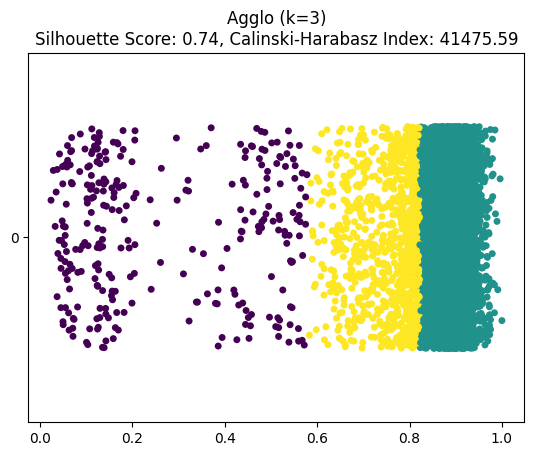

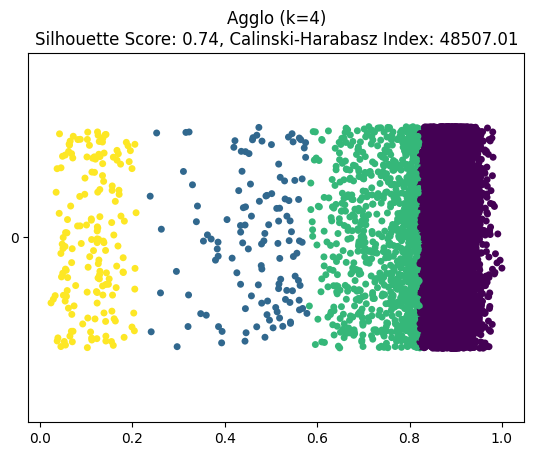

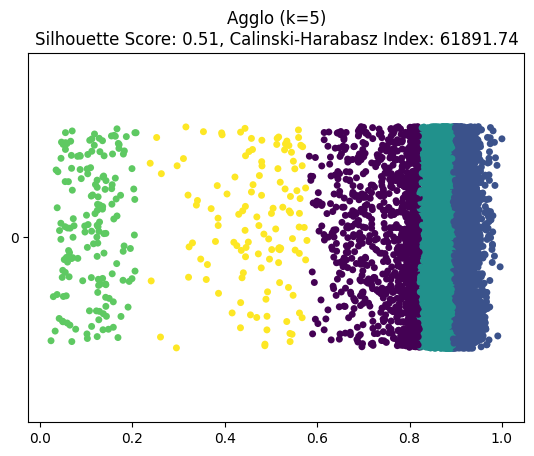

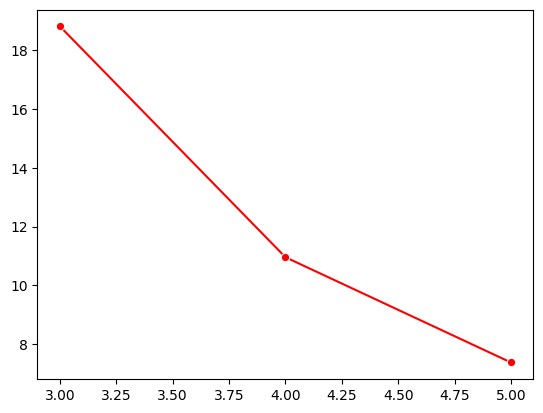

[Agglo] Оптимальное k по Calinski-Harabasz: 5, score: 61891.74
[Agglo] Оптимальное k по Silhouette: 4, score: 0.74
[Agglo] Оптимальное k по WSS: 4


In [ ]:
k_range = range(3, 6)

agglo_sil = []
agglo_ch = []
agglo_wss = []

for k in k_range:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(df)

    s_score = silhouette_score(df, labels)
    ch_score = calinski_harabasz_score(df, labels)
    wss_value = compute_wss(df, labels)

    agglo_sil.append(s_score)
    agglo_ch.append(ch_score)
    agglo_wss.append(wss_value)

    sns.stripplot(data=df, jitter=0.3, c=labels, orient="h")
    plt.title(f"Agglo (k={k})\nSilhouette Score: {s_score:.2f}, "
              f"Calinski-Harabasz Index: {ch_score:.2f}")
    plt.show()

sns.lineplot(x=list(k_range), y=wss_values, marker='o', color='red')
plt.show()

best_k_agglo_ch = k_range[np.argmax(agglo_ch)]
best_ch_score = max(agglo_ch)

best_k_agglo_sil = k_range[np.argmax(agglo_sil)]
best_sil_score = max(agglo_sil)

print(f"[Agglo] Оптимальное k по Calinski-Harabasz: {best_k_agglo_ch}, "
      f"score: {best_ch_score:.2f}")
print(f"[Agglo] Оптимальное k по Silhouette: {best_k_agglo_sil}, "
      f"score: {best_sil_score:.2f}")
print(f"[Agglo] Оптимальное k по WSS: 4")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Выбор алгоритма и визуализация

Метод естественных разрывов Дженкса и Оптимизированный метод K-средних показали наиболее хорошие результаты. Выбираем метод естественных разрывов потому что он чаще используется в работе геоинформационных систем и имеет более широкую поддержку и документацию.
Наиболее оптимальмый выбором кластеров, основываясь на показаниях всех метрик, будет выбор k = 4.

Сохраняем результат

In [ ]:
jenks_data = data.copy()
breaks = jenkspy.jenks_breaks(jenks_data['value'], n_classes=4)
jenks_data['class'] = pd.cut(jenks_data['value'], bins=breaks, labels=False, include_lowest=True)

wb = load_workbook('/content/drive/MyDrive/НИР/v9123_with_classes.xlsx')
ws = wb.active

color_mapping = {
    0: 'FF0000',  # Red
    1: 'FFA500', # Orange
    2: 'FFFF00',  # Yellow
    3: '00FF00',  # Green
}

for index, row in jenks_data.iterrows():
    value_cell = ws.cell(row=index + 2, column=1)
    class_value = row['class']

    if class_value in color_mapping:
        fill_color = PatternFill(start_color=color_mapping[class_value], end_color=color_mapping[class_value], fill_type="solid")
        value_cell.fill = fill_color

wb.save('/content/drive/MyDrive/НИР/v9123_colored.xlsx')

Импортируем координаты поля

In [ ]:
field = gpd.read_file('/content/drive/MyDrive/НИР/result analyze.geojson')

field.head()

,value,geometry
0,0.67928,"POLYGON ((39.57833 45.32084, 39.57845 45.32084..."
1,0.82277,"POLYGON ((39.57858 45.32084, 39.57871 45.32084..."
2,0.78404,"POLYGON ((39.57807 45.32075, 39.5782 45.32075,..."
3,0.80819,"POLYGON ((39.5782 45.32075, 39.57833 45.32075,..."
4,0.78531,"POLYGON ((39.57833 45.32075, 39.57845 45.32075..."


Визуализируем результат

<Axes: >

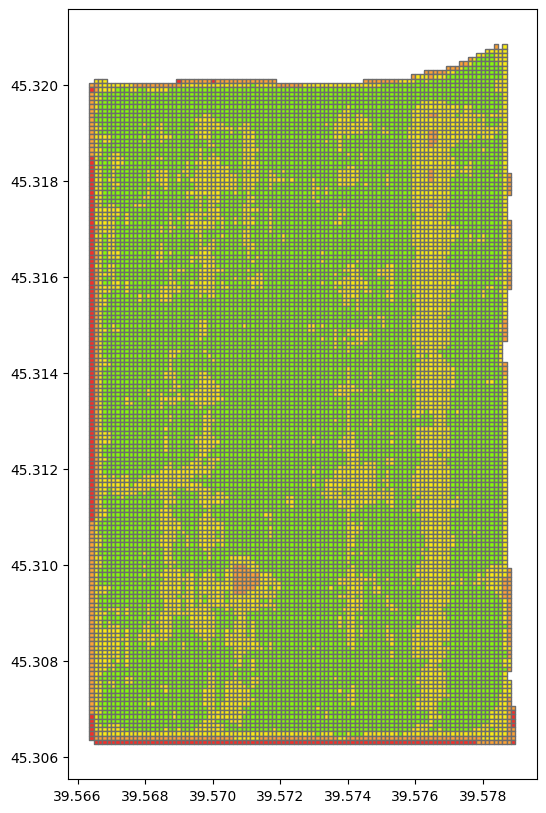

In [ ]:
colors = {0: '#F42E2A', 1: '#FDA235', 2: '#F9EC15', 3: '#87F90B'}

cmap = mcolors.ListedColormap([colors[val] for val in sorted(colors.keys())])
fig, ax = plt.subplots(figsize=(10, 10))
field.plot(column=jenks_data['class'], cmap=cmap, ax=ax, edgecolor='#6D6C6C')